In [18]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
plt.style.use('dark_background')

# 1. Load Data 

In [2]:
data=pd.read_csv("NSE-TATAGLOBAL.csv",parse_dates=True)
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


# 2. Understand Data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2035.0,1.497137e+02,4.866451e+01,81.10,120.025,141.50,157.175,327.70
High,2035.0,1.519928e+02,4.941311e+01,82.80,122.100,143.40,159.400,328.75
Low,2035.0,1.472939e+02,4.793196e+01,80.00,118.300,139.60,155.150,321.65
Last,2035.0,1.494743e+02,4.873257e+01,81.00,120.075,141.10,156.925,325.95
Close,2035.0,1.494503e+02,4.871204e+01,80.95,120.050,141.25,156.900,325.75
Total Trade Quantity,2035.0,2.335681e+06,2.091778e+06,39610.00,1146444.500,1783456.00,2813594.000,29191015.00
Turnover (Lacs),2035.0,3.899981e+03,4.570768e+03,37.04,1427.460,2512.03,4539.015,55755.08


In [5]:
data.Date=pd.to_datetime(data.Date)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  2035 non-null   datetime64[ns]
 1   Open                  2035 non-null   float64       
 2   High                  2035 non-null   float64       
 3   Low                   2035 non-null   float64       
 4   Last                  2035 non-null   float64       
 5   Close                 2035 non-null   float64       
 6   Total Trade Quantity  2035 non-null   int64         
 7   Turnover (Lacs)       2035 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 127.3 KB


In [7]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


# 3. Data Visualization

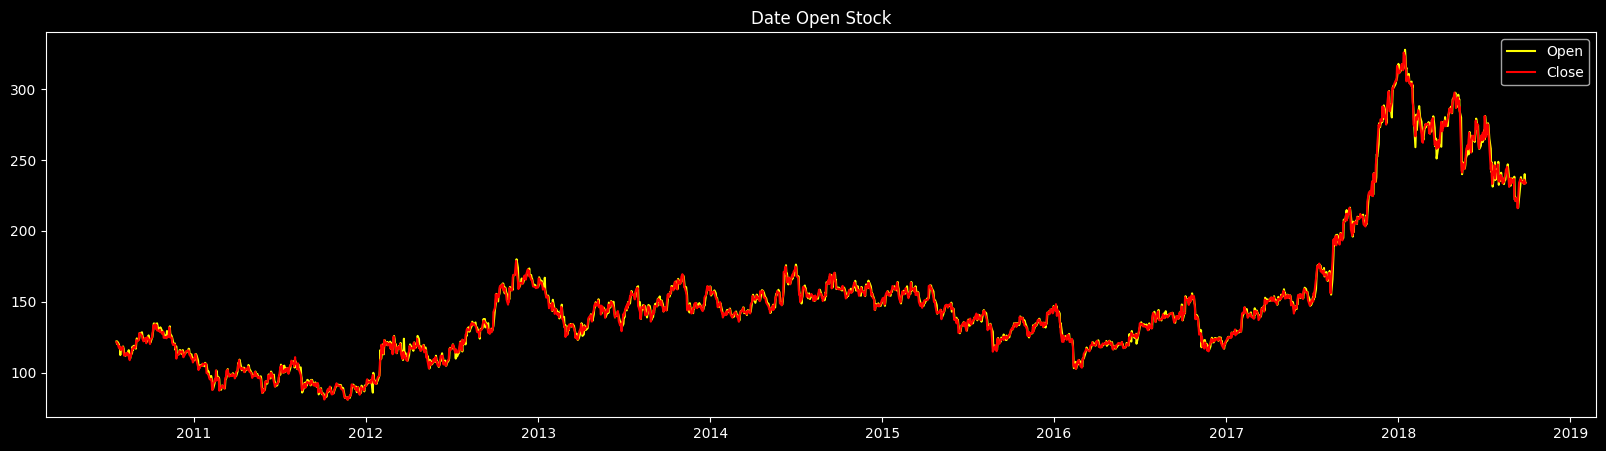

In [8]:
plt.figure(figsize=(20,5))
plt.plot(data["Date"],data['Open'],label = "Open",color="yellow")
plt.plot(data["Date"],data['Close'],label = "Close",color="red")
plt.title("Date Open Stock")
plt.legend()

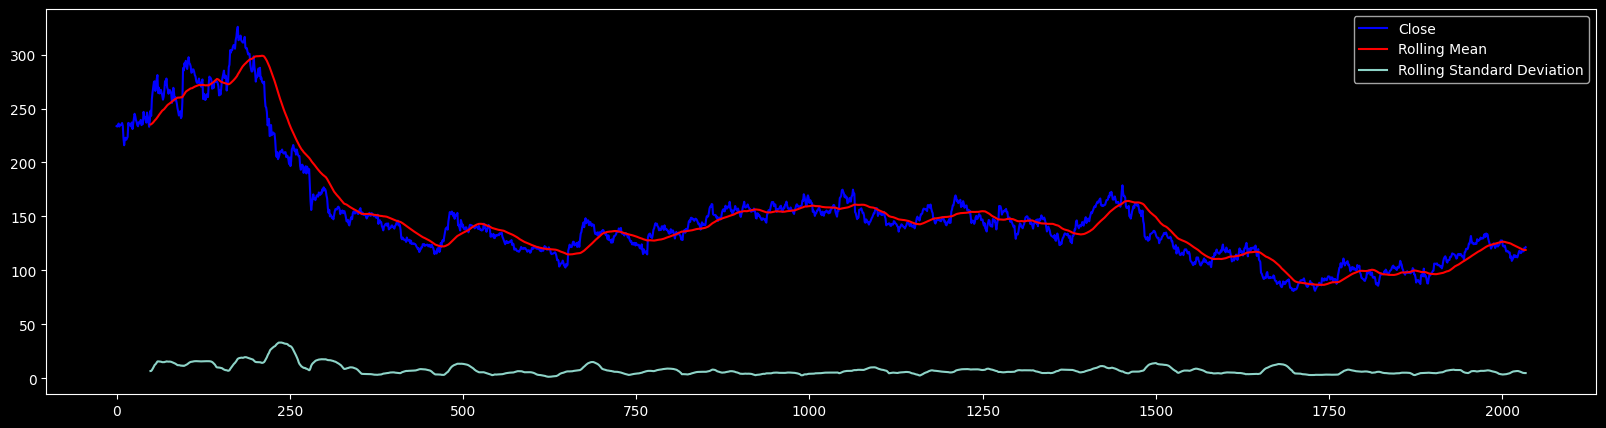

In [9]:
close = data['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()
plt.figure(figsize=(20,5))
data['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns\n')

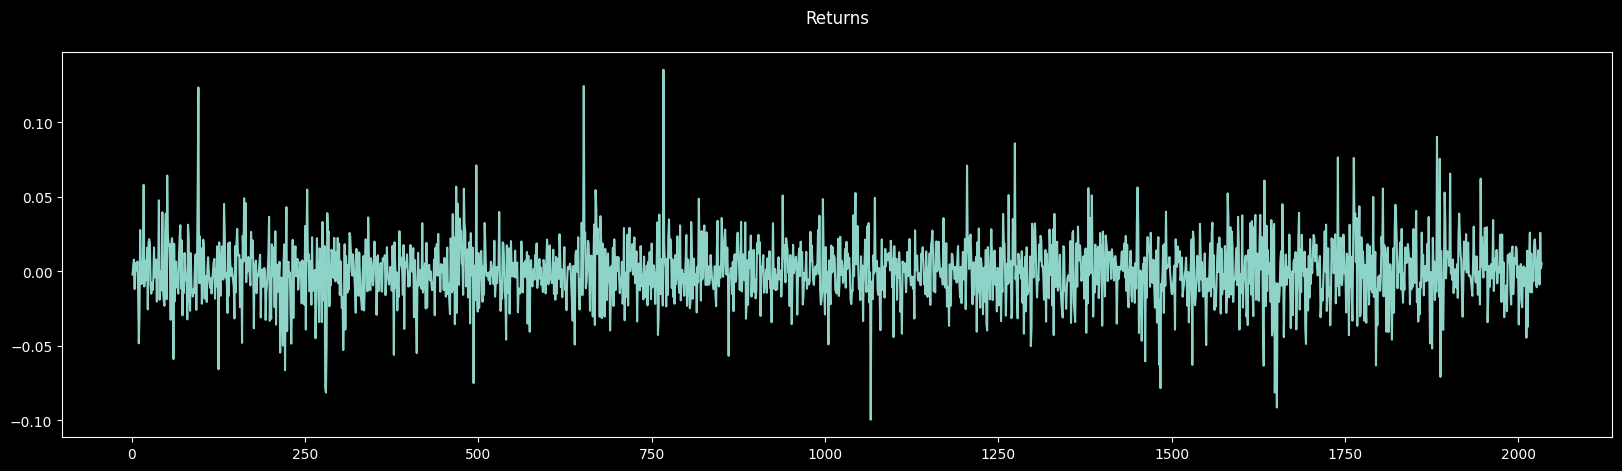

In [10]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize=(20,5))
returns.plot(label='Return')
plt.title("Returns\n")

In [11]:
#split Data
train = data[:1000]
test = data[1000:]

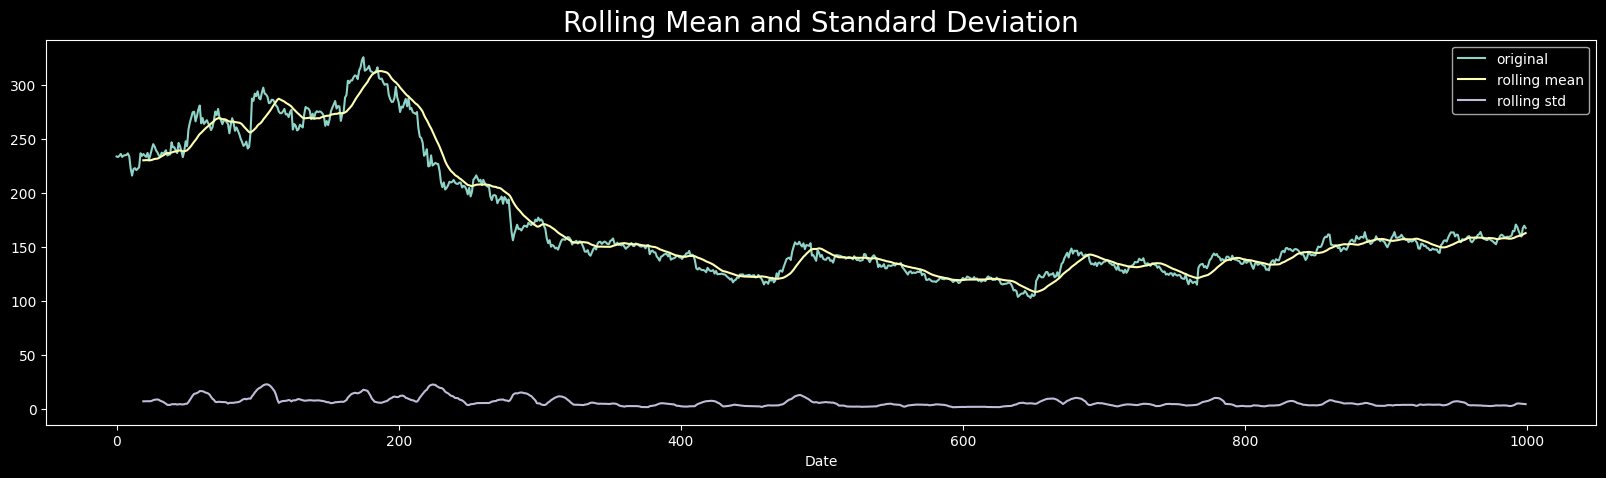

Results of dickey fuller test
ADF Test Statistic : -1.2003051654129013
p-value : 0.6734644237015394
#Lags Used : 16
Number of Observations Used : 983
Weak evidence against null hypothesis, time series is non-stationary 


In [12]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
     rolmean = timeseries.rolling(20).mean()
     rolstd = timeseries.rolling(20).std()

     #Plot rolling statistics:
     plt.figure(figsize=(20,5))
     plt.plot(timeseries, label = 'original')
     plt.plot(rolmean,  label = 'rolling mean')
     plt.plot(rolstd, label = 'rolling std')
     plt.xlabel('Date')
     plt.legend()
     plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
     plt.show(block = False)

     print('Results of dickey fuller test')
     result = adfuller(timeseries, autolag = 'AIC')
     labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
     for value,label in zip(result, labels):
        print(label+' : '+str(value) )
     if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
     else:
        print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

# 4. Model

In [20]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
close_df=scaler.fit_transform(np.array(data['Close']).reshape(-1,1))

In [21]:
close_df

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

In [22]:
training_size = int(len(close_df)*0.75)
test_size = len(close_df)-training_size
train_data,test_data = close_df[0:training_size,:],close_df[training_size:len(close_df),:1]

In [26]:
print("Train Data : ",len(train_data))
print("Test Data : ",len(test_data))

Train Data :  1526
Test Data :  509


In [27]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [28]:
X_train, Y_train = create_dataset(train_data, 100)
X_test, Y_test = create_dataset(test_data, 100)

In [29]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [31]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])


# Train the model
hist=model.fit(X_train, Y_train, batch_size=1, epochs=1)


1425/1425 [==============================] - 87s 57ms/step - loss: 0.0030 - accuracy: 7.0175e-04


In [37]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

13/13 [==============================] - 1s 51ms/step
